Account for AOI reflection losses (in full mode only)
=========================================

In this section, we will learn how:

- ``pvfactors`` accounts for AOI losses by default
- how to account for AOI-dependent reflection losses for direct, circumsolar, and horizon irradiance components
- how to account for AOI-dependent reflection losses for isotropic and reflection irradiance components
- how to run all of this using the ``pvfactors`` run functions

Imports and settings

In [1]:
# Import external libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})
# Paths
LOCAL_DIR = os.getcwd()
DATA_DIR = os.path.join(LOCAL_DIR, 'data')
filepath = os.path.join(DATA_DIR, 'test_df_inputs_MET_clearsky_tucson.csv')

RUN_FIXED_TILT = True

Let's define a few helper functions that will help clarify the notebook

In [2]:
# Helper functions for plotting and simulation
def plot_irradiance(df_report):
    # Plot irradiance
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    # Plot back surface irradiance
    df_report[['qinc_back', 'qabs_back']].plot(ax=ax[0])
    ax[0].set_title('Back surface irradiance')
    ax[0].set_ylabel('W/m2')
    # Plot front surface irradiance
    df_report[['qinc_front', 'qabs_front']].plot(ax=ax[1])
    ax[1].set_title('Front surface irradiance')
    ax[1].set_ylabel('W/m2')
    plt.show()
    
def plot_aoi_losses(df_report):
    # plotting AOI losses
    f, ax = plt.subplots(figsize=(5.5, 4))
    df_report[['aoi_losses_back_%']].plot(ax=ax)
    df_report[['aoi_losses_front_%']].plot(ax=ax)
    # Adjust axes
    ax.set_ylabel('%')
    ax.legend(['AOI losses back PV row', 'AOI losses front PV row'])
    ax.set_title('AOI losses')
    plt.show()
    
# Create a function that will build a simulation report
def fn_report(pvarray): 
    # Get irradiance values
    report = {'qinc_back': pvarray.ts_pvrows[1].back.get_param_weighted('qinc'),
              'qabs_back': pvarray.ts_pvrows[1].back.get_param_weighted('qabs'),
              'qinc_front': pvarray.ts_pvrows[1].front.get_param_weighted('qinc'),
              'qabs_front': pvarray.ts_pvrows[1].front.get_param_weighted('qabs')}
    # Calculate AOI losses
    report['aoi_losses_back_%'] = (report['qinc_back'] - report['qabs_back']) / report['qinc_back'] * 100.
    report['aoi_losses_front_%'] = (report['qinc_front'] - report['qabs_front']) / report['qinc_front'] * 100.
    # Return report
    return report

### Get timeseries inputs

In [3]:
def export_data(fp):
    tz = 'US/Arizona'
    df = pd.read_csv(fp, index_col=0)
    df.index = pd.DatetimeIndex(df.index).tz_convert(tz)
    return df

df = export_data(filepath)
df_inputs = df.iloc[:48, :]

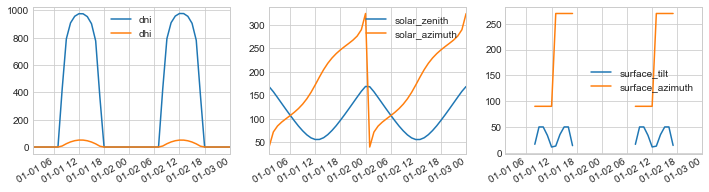

In [4]:
# Plot the data
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
df_inputs[['dni', 'dhi']].plot(ax=ax1)
df_inputs[['solar_zenith', 'solar_azimuth']].plot(ax=ax2)
df_inputs[['surface_tilt', 'surface_azimuth']].plot(ax=ax3)
plt.show()

In [5]:
# Use a fixed albedo
albedo = 0.2

### Prepare PV array parameters

In [6]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
}

### Default AOI loss behavior

In ``pvfactors``:

- ``qinc`` is the total incident irradiance on a surface, and it does not account for reflection losses
- but ``qabs``, which is the total absorbed irradiance by a surface, does accounts for it.

By default, ``pvfactors`` assumes that all reflection losses (or AOI losses) are diffuse; i.e. they do not depend on angle of incidence (AOI). Here is an example.  

Let's run a full mode simulation (reflection equilibrium) and compare the calculated incident and absorbed irradiance on both sides of a PV row in a modeled PV array. We'll use 3% reflection for PV row front surfaces, and 5% for the back surfaces.

In [7]:
from pvfactors.geometry import OrderedPVArray
# Create PV array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)

In [8]:
from pvfactors.engine import PVEngine
from pvfactors.irradiance import HybridPerezOrdered
# Create irradiance model
irradiance_model = HybridPerezOrdered(rho_front=0.03, rho_back=0.05)
# Create engine
engine = PVEngine(pvarray, irradiance_model=irradiance_model)
# Fit engine to data
engine.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
           df_inputs.solar_zenith, df_inputs.solar_azimuth, 
           df_inputs.surface_tilt, df_inputs.surface_azimuth, 
           albedo)

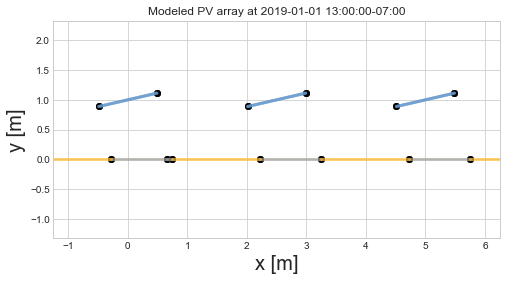

In [9]:
# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(8, 4))
pvarray.plot_at_idx(12, ax)
plt.title('Modeled PV array at {}'.format(df_inputs.index[12]))
plt.show()

In [10]:
# Run full mode simulation
report = engine.run_full_mode(fn_build_report=fn_report)
# Turn report into dataframe
df_report = pd.DataFrame(report, index=df_inputs.index)

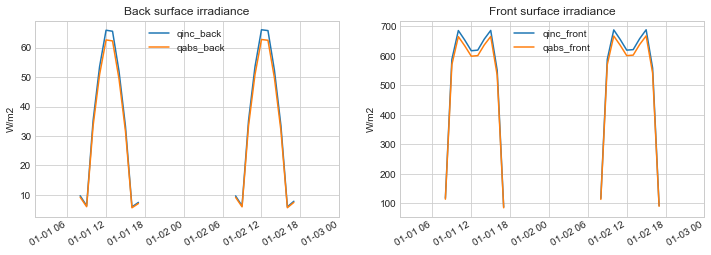

In [11]:
plot_irradiance(df_report)

Let's plot the back AOI losses

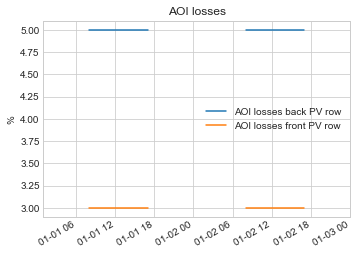

In [12]:
plot_aoi_losses(df_report)

As shown above, by default ``pvfactors`` apply constant values of AOI losses for all the surfaces in the system, and for all the incident irradiance components: 

- 3% loss for the irradiance incident on front of PV rows, which corresponds to the chosen ``rho_front`` in the irradiance model
- 5% loss for the irradiance incident on back of PV rows, which corresponds to the chosen ``rho_back`` in the irradiance model

### Use an ``fAOI`` function in the irradiance model

The next step that can improve the AOI loss calculation, especially for the PV row front surface that receives a lot of direct light, would be to use reflection losses that would be dependent on the AOI, and that would be applied to all the irradiance model components: direct, circumsolar, and horizon light components.

#### What is an ``fAOI`` function?

The ``fAOI`` function that the users need to provide takes an angle of incidence as input (AOI measured in degrees and against the surface horizontal - from 0 to 180 deg, **not** against the surface normal vector - which would have been from 0 to 90 deg), and it returns a transmission value for the incident light. So it's effectively a factor that removes reflection losses.

Let's see what this looks like. First, let's create such a function using a ``pvfactors`` utility function, and then we'll plot it.

Given a [pvlib](https://pvlib-python.readthedocs.io/en/stable/index.html) module database name, you can create an ``fAOI`` function as follows using pvfactors.

In [13]:
# import utility function
from pvfactors.viewfactors.aoimethods import faoi_fn_from_pvlib_sandia
# Choose a module name
module_name = 'SunPower_128_Cell_Module___2009_'
# Create an faoi function
faoi_function = faoi_fn_from_pvlib_sandia(module_name)

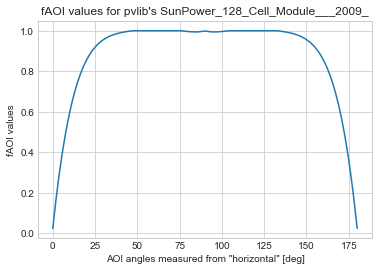

In [14]:
# Plot faoi function values
aoi_values = np.linspace(0, 180, 100)
faoi_values = faoi_function(aoi_values)

f, ax = plt.subplots()
ax.plot(aoi_values, faoi_values)
ax.set_title('fAOI values for pvlib\'s {}'.format(module_name))
ax.set_ylabel('fAOI values')
ax.set_xlabel('AOI angles measured from "horizontal" [deg]')
plt.show()

As expected, there are less reflection losses for incident light rays normal to the surface than everywhere else.

#### Use the ``fAOI`` function

It's then easy to use the created ``fAOI`` function in the irradiance models. It just has to be passed to the model at initialization.  

For this example, we will use the same fAOI function for the front and back surfaces of the PV rows.

In [15]:
# Create irradiance model with fAOI function
irradiance_model = HybridPerezOrdered(faoi_fn_front=faoi_function, faoi_fn_back=faoi_function)

Then pass the model to the ``PVEngine`` and run the simulation as usual.

In [16]:
# Create engine
engine = PVEngine(pvarray, irradiance_model=irradiance_model)
# Fit engine to data
engine.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
           df_inputs.solar_zenith, df_inputs.solar_azimuth, 
           df_inputs.surface_tilt, df_inputs.surface_azimuth, 
           albedo)
# Run full mode simulation
report = engine.run_full_mode(fn_build_report=fn_report)
# Turn report into dataframe
df_report = pd.DataFrame(report, index=df_inputs.index)

Let's now see what the irradiance and AOI losses look like.

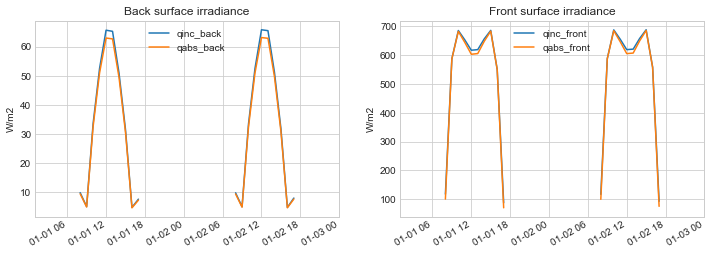

In [17]:
plot_irradiance(df_report)

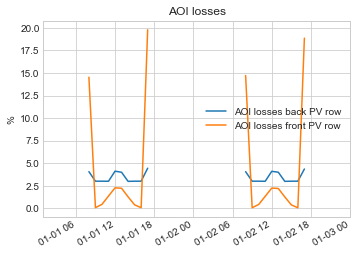

In [18]:
plot_aoi_losses(df_report)

We can now see the changes in AOI losses, which now use the ``fAOI`` function for the direct, circumsolar, and horizon light components. But it still uses the constant ``rho_front`` and ``rho_back`` values for the reflection and isotropic components of the incident light on the surfaces.

### Advanced: use an ``fAOI`` function for the (ground and array) reflection and isotropic components

The more advanced use is to apply the ``fAOI`` losses to the reflection and isotropic component of the light incident on the PV row surfaces.  

In order to do so you simply need to pass the ``fAOI`` function to the view factor calculator before initializing the ``PVEngine``.

In this case, the simulation workflow will be as follows:

- the ``PVEngine`` will still calculate the equilibrium of reflections assuming diffuse surfaces and constant reflection losses
- it will then use the calculated radiosity values and apply the ``fAOI`` using an integral combining the AOI losses and the view factor integrands, as described in the theory section, and similarly to [Marion, B., et al (2017)](https://www.osti.gov/servlets/purl/1364146)

#### A word of caution

The users should be careful when using ``fAOI`` losses with the view factor calculator for the following reasons:

- in order to be fully consistent in the ``PVEngine`` calculations, it is wiser to re-calculate a global hemispherical reflectivity value using the ``fAOI`` function, which will be used in the reflection equilibrium calculation
- the method used for accounting ``fAOI`` losses in reflections is physically valid only if the surfaces are "infinitesimal" because it uses view factor formulas only valid in this case (see http://www.thermalradiation.net/sectionb/B-71.html). So in order to make it work in ``pvfactors``, you'll need to discretize the PV row sides into smaller segments
- the method relies on the numerical calculation of an integral, and that calculation will converge only given a sufficient number of integral points (which can be provided to the ``pvfactors`` view factor calculator). [Marion, B., et al (2017)](https://www.osti.gov/servlets/purl/1364146) seems to be using 180 points, but in ``pvfactors``' implementation it doesn't look like it's enough for the integral to converge, so we'll use 1000 integral points in this example
- the two points above slow down the computation time by an order of magnitude. 8760 simulations that normally take a couple of seconds to run with ``pvfactors``'s full mode can then take up to a minute or two

#### Apply ``fAOI`` losses to reflection terms

Discretize the PV row sides of the PV array:

In [19]:
# first let's discretize the PV row sides
pvarray_parameters.update({
    'cut': {1: {'front': 5, 'back': 5}}
})
# Create a new pv array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)

Add ``fAOI`` losses to the view factor calculator, and use 1000 integration points

In [20]:
from pvfactors.viewfactors import VFCalculator

vf_calculator = VFCalculator(faoi_fn_front=faoi_function, faoi_fn_back=faoi_function, 
                             n_aoi_integral_sections=1000)

Re-calculate global hemispherical reflectivity values based on ``fAOI`` function

In [21]:
# For back PV row surface
is_back = True
rho_back = vf_calculator.vf_aoi_methods.rho_from_faoi_fn(is_back)
# For front PV row surface
is_back = False
rho_front = vf_calculator.vf_aoi_methods.rho_from_faoi_fn(is_back)

# Print results
print('Reflectivity values for front side: {}, and back side: {}'.format(rho_front, rho_back))

Reflectivity values for front side: 0.029002539185428944, and back side: 0.029002539185428944


Since we're using the same ``fAOI`` function for front and back sides, we now get the same global hemispherical reflectivity values.  

We can now create the irradiance model.

In [22]:
irradiance_model = HybridPerezOrdered(rho_front=rho_front, rho_back=rho_back,
                                      faoi_fn_front=faoi_function, faoi_fn_back=faoi_function)

Simulations can then be run the usual way:

In [23]:
# Create engine
engine = PVEngine(pvarray, vf_calculator=vf_calculator,
                  irradiance_model=irradiance_model)
# Fit engine to data
engine.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
           df_inputs.solar_zenith, df_inputs.solar_azimuth, 
           df_inputs.surface_tilt, df_inputs.surface_azimuth, 
           albedo)

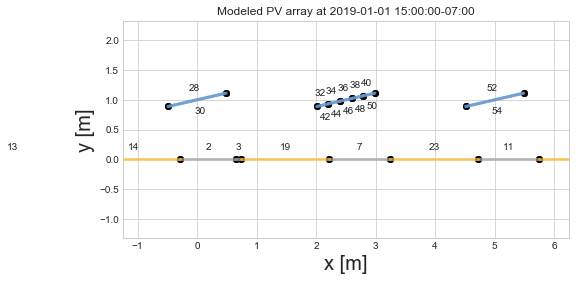

In [24]:
# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(8, 4))
ax = pvarray.plot_at_idx(12, ax, with_surface_index=True)
plt.title('Modeled PV array at {}'.format(df_inputs.index[14]))
plt.show()

Run the simulation:

In [25]:
# Run full mode simulation
report = engine.run_full_mode(fn_build_report=fn_report)
# Turn report into dataframe
df_report = pd.DataFrame(report, index=df_inputs.index)

Let's now see what the irradiance and AOI losses look like.

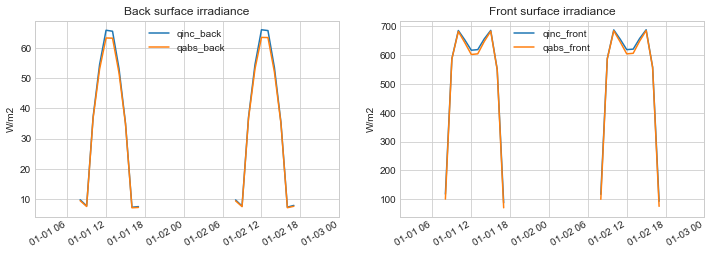

In [26]:
plot_irradiance(df_report)

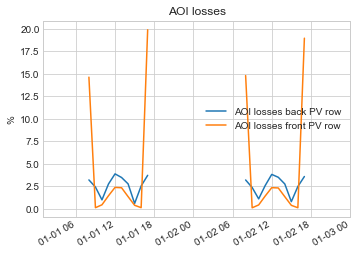

In [27]:
plot_aoi_losses(df_report)

This is the way to apply ``fAOI`` losses to all the irradiance components in a ``pvfactors`` simulation.